In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_eo

pytorch_eo.__version__

'2024.05.03'

In this example we are going to train 3 image classifiers using the [BigEarthNet](http://bigearth.net/) dataset:

1. Using S1 images
2. Using S2 images
3. Using both S1 and S2 images in a Data Fusion configuration.

This dataset needs to be downloaded from the [BigEarthNet website](http://bigearth.net/). Once downloaded you will need a folder with the following structure:

- BigEarthNet-S1-v1.0
- BigEarthNet-v1.0 
- patches_with_cloud_and_shadow.csv
- patches_with_seasonal_snow.csv

Then you can instantiate the Dataset as follows, selecting the sensors and bands that you want to work with and, optionally, grouping the classes into a smaller number of labels.

## Sentinel 1

In [3]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1

ds = BigEarthNet(
    path="/fastdata/BigEarthNet",               # path to dataset
    processed_data_path="data/BigEarthNet",     # path to save processed datafiles
    batch_size=25, 
	bands={Sensors.S1: [S1.VH, S1.VV]},         # use only S1 with VH and VV bands
    verbose=True,
    label_groups=LABELS19                       # group original labels in 19 superclasses
)

ds.setup()

Loading ... processed_S1_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


The first time you run the code for a new combination of sensors or label groups it will take a while to pre-process everything, afterwards it will be faster.

In [5]:
ds.df

,s1_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Arable land, Broad-leaved forest, Mixed fores...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Coniferous forest, Beaches, dunes, sands, Mar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,"[Coniferous forest, Mixed forest, Marine waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Industrial or commercial units, Arable land, ...","[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Broad-leaved forest, Coniferous forest, Mixed...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,"[Arable land, Mixed forest, Inland waters]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [6]:
ds.num_classes, ds.classes

(19,
 ['Urban fabric',
  'Industrial or commercial units',
  'Arable land',
  'Permanent crops',
  'Pastures',
  'Complex cultivation patterns',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Agro-forestry areas',
  'Broad-leaved forest',
  'Coniferous forest',
  'Mixed forest',
  'Natural grassland and sparsely vegetated areas',
  'Moors, heathland and sclerophyllous vegetation',
  'Transitional woodland, shrub',
  'Beaches, dunes, sands',
  'Inland wetlands',
  'Coastal wetlands',
  'Inland waters',
  'Marine waters'])

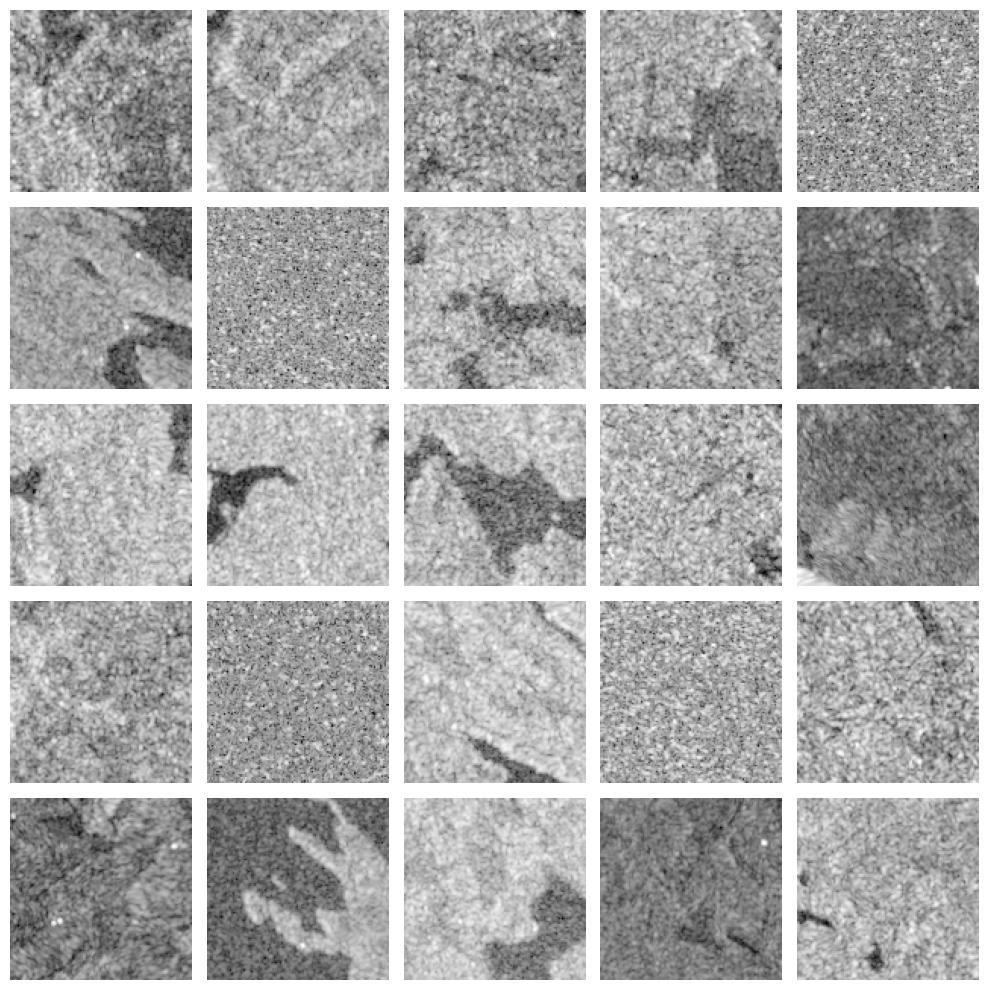

In [7]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
import lightning as L  #import pytorch_lightning as pl
from sklearn.metrics import average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from einops import rearrange
from pytorch_eo.tasks.classification import ImageMultilabelClassification
import timm
import torch
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

train_trans = A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Transpose(),
        A.RandomRotate90(),
        A.Lambda(image=clip),
        A.Lambda(image=add_channel),
        ToTensorV2(),
    ])

val_trans = A.Compose([
    A.Lambda(image=clip),
    A.Lambda(image=add_channel),
    ToTensorV2(),
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
    bands={Sensors.S1: [S1.VH, S1.VV]}, 
    label_groups=LABELS19,
    train_trans=train_trans, 
    val_trans=val_trans,
    num_workers=8,
    pin_memory=True,
)

model = timm.create_model('resnet34', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 3e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} )

trainer = L.Trainer(
        devices=1,
        accelerator='cuda',
        precision="16-mixed",
        max_epochs=10,
        limit_train_batches=100,
        limit_val_batches=100,
        #logger=WandbLogger(project="bigearthnet-classification-S1", name='resnet34'), 
        callbacks=[
            ModelCheckpoint(
                monitor="val_map",
                mode="max",
                save_top_k=1,
                dirpath="checkpoints",
                filename=f"{'resnet34'}-{{epoch:02d}}-{{val_map:.4f}}-{{S1}}",
            )
        ],
    )

torch.set_float32_matmul_precision('high') # more perf on some GPUs
trainer.fit(task, ds)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Loading ... processed_S1_LABELS19.json


/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/anna/Desktop/pytorchEO/examples/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 21.3 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.165    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluate

In [33]:
import lightning as L  #import pytorch_lightning as pl
from sklearn.metrics import average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from einops import rearrange
from pytorch_eo.tasks.classification import ImageMultilabelClassification
import timm
import torch
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1

def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

val_trans = A.Compose([
    A.Lambda(image=clip),
    A.Lambda(image=add_channel),
    ToTensorV2(),
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
    bands={Sensors.S1: [S1.VH, S1.VV]}, 
    label_groups=LABELS19,
    train_trans=None, 
    val_trans=val_trans,
    num_workers=8,
    pin_memory=True,
)

ds.setup()

model = timm.create_model('resnet34', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

task = ImageMultilabelClassification.load_from_checkpoint("checkpoints/resnet34-epoch=09-val_map=0.7281-S1=0.ckpt", model=model, num_classes=ds.num_classes)

Loading ... processed_S1_LABELS19.json


/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [34]:
# extract batch from test dataloader
import matplotlib as plt
from matplotlib.figure import Figure

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
batch['image'] = batch['image'].permute(0, 3, 1, 2) 
imgs, labels = batch['image'], batch['labels']

# compute predictions
task.cpu()
preds = task.predict(batch)
preds = torch.sigmoid(preds) > 0.5

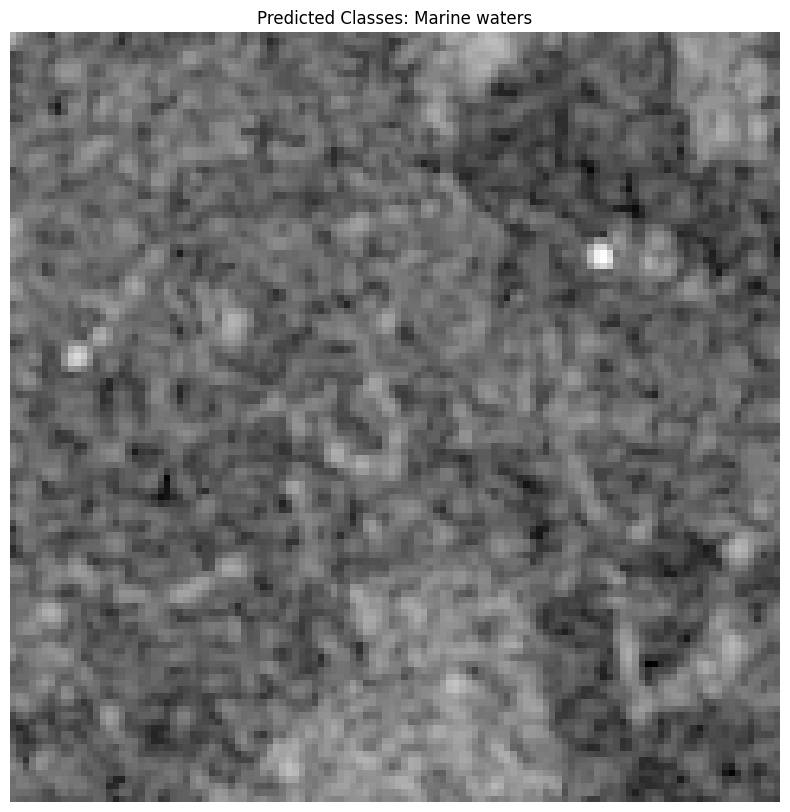

Predicted Classes for the Image: Marine waters


In [35]:
import matplotlib.pyplot as plt
# Select the first image and its corresponding prediction
img = imgs[1].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
#img = np.clip(img, 0, 1)  # Ensure image values are in range [0, 1]
pred = preds[1]  # Select the first image's predictions

class_labels = [
    "Urban fabric", "Industrial or commercial units", "Arable land", "Permanent crops", 
    "Pastures", "Complex cultivation patterns", 
    "Land principally occupied by agriculture, with significant areas of natural vegetation", 
    "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest", 
    "Natural grassland and sparsely vegetated areas", "Moors, heathland and sclerophyllous vegetation", 
    "Transitional woodland, shrub", "Beaches, dunes, sands", "Inland wetlands", 
    "Coastal wetlands", "Inland waters", "Marine waters"
]

# Extract class labels for the predictions above threshold
predicted_classes = [class_labels[i] for i in range(len(pred)) if pred[i] == 1]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot image
ax.imshow(img[...,0], cmap='gray')
ax.set_title(f"Predicted Classes: {', '.join(predicted_classes)}")
ax.axis('off')

plt.show()

print(f"Predicted Classes for the Image: {', '.join(predicted_classes)}")

## Load model from onnx file

In [7]:
import onnxruntime
import numpy as np

filepath = "/home/anna/Desktop/pytorchEO/data/BigEarthNetModels/BEN_S1_34/BigEarthNet-s1-resnet34.onnx"
ort_session = onnxruntime.InferenceSession(filepath)

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch['image'], batch['labels']


input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()} # batch of images of size Bx3xHxW
ort_outs = ort_session.run(None, ort_inputs)
mask = ort_outs[0] # batch of labels

## Sentinel 2

In [9]:
from pytorch_eo.datasets.sensors import S2

ds = BigEarthNet(
    path="/fastdata/BigEarthNet",                       # path to dataset
    processed_data_path="data/BigEarthNet",             # path to save processed datafiles
    batch_size=25, 
	bands={Sensors.S2: [S2.red, S2.green, S2.blue]},    # use only S2 with RGB bands
    verbose=True,
    label_groups=LABELS19                               # group original labels in 19 superclasses
)

ds.setup()

Loading ... processed_S2_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


In [10]:
ds.df

,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Broad-leaved forest, Mixed forest, Transition...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Urban fabric, Land principally occupied by ag...","[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Transitional woodland, shr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
4,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Broad-leaved forest]","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Mixed forest, Inland waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Complex cultivation patterns, La...","[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest, Transitional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."


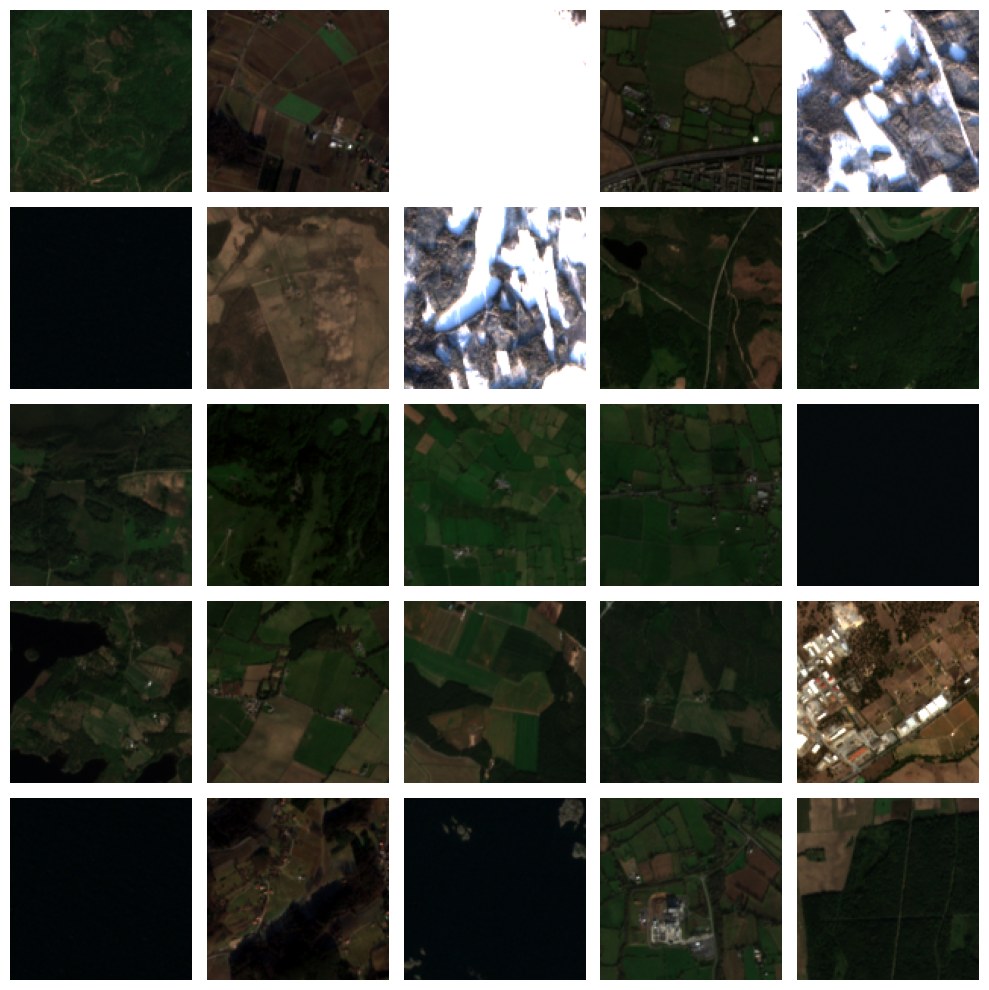

In [11]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    img = to_uint8(img, 0, 4000)
    ax.imshow(img) 
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
def clip(x, **kwargs): return np.clip(x / 4000, 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

train_trans = A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Transpose(),
        A.RandomRotate90(),
        A.Lambda(image=clip),
        A.Lambda(image=add_channel),
        ToTensorV2(),
    ])

val_trans = A.Compose([
    A.Lambda(image=clip),
    A.Lambda(image=add_channel),
    ToTensorV2(),
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
    bands={Sensors.S2: [S2.red, S2.green, S2.blue]},
    label_groups=LABELS19,
    train_trans=train_trans, 
    val_trans=val_trans,
    num_workers=8,
    pin_memory=True,
)


model = timm.create_model('resnet34', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} )

trainer = L.Trainer(
        devices=1,
        accelerator='cuda',
        precision="16-mixed",
        max_epochs=10,
        limit_train_batches=100,
        limit_val_batches=100,
        logger=WandbLogger(project="bigearthnet-classification-S2", name='resnet34'),
        callbacks=[
            ModelCheckpoint(
                monitor="val_map",
                mode="max",
                save_top_k=1,
                dirpath="checkpoints",
                filename=f"{'resnet34'}-{{epoch:02d}}-{{val_map:.4f}}-{{S2}}",
            )
        ],
    )

torch.set_float32_matmul_precision('high') # more perf on some GPUs
trainer.fit(task, ds)

/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading ... processed_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.745    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Evaluate

In [39]:
import lightning as L  #import pytorch_lightning as pl
from sklearn.metrics import average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from einops import rearrange
from pytorch_eo.tasks.classification import ImageMultilabelClassification
import timm
import torch
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S2

def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

val_trans = A.Compose([
    A.Lambda(image=clip),
    A.Lambda(image=add_channel),
    ToTensorV2(),
])

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=64, 
    bands={Sensors.S2: [S2.red, S2.green, S2.blue]},
    label_groups=LABELS19,
    train_trans=train_trans, 
    val_trans=val_trans,
    num_workers=8,
    pin_memory=True,
)

ds.setup()

model = timm.create_model('resnet34', pretrained=True, num_classes=ds.num_classes, in_chans=ds.in_chans)

task = ImageMultilabelClassification.load_from_checkpoint("checkpoints/resnet34-epoch=08-val_map=0.7860-S2=0.ckpt", model=model, num_classes=ds.num_classes)

Loading ... processed_S2_LABELS19.json


/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [40]:
# extract batch from test dataloader
import matplotlib as plt
from matplotlib.figure import Figure

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
batch['image'] = batch['image'].permute(0, 3, 1, 2) 
imgs, labels = batch['image'], batch['labels']

# compute predictions
task.cpu()
preds = task.predict(batch)
preds = torch.sigmoid(preds) > 0.5

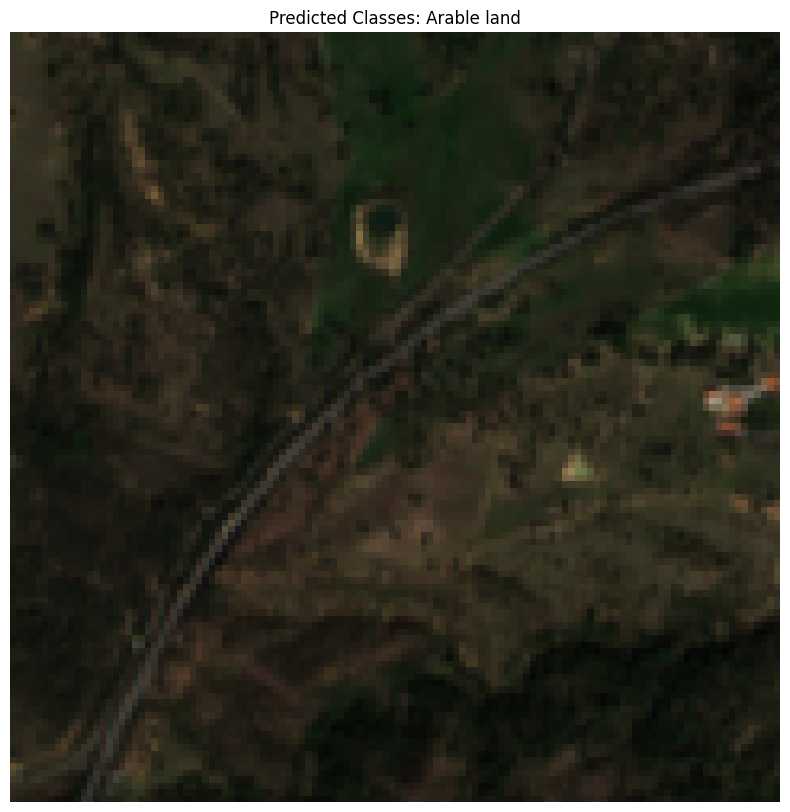

Predicted Classes for the Image: Arable land


In [42]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

# Select the first image and its corresponding prediction
img = imgs[1].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
#img = np.clip(img, 0, 1)  # Ensure image values are in range [0, 1]
pred = preds[1]  # Select the first image's predictions

class_labels = [
    "Urban fabric", "Industrial or commercial units", "Arable land", "Permanent crops", 
    "Pastures", "Complex cultivation patterns", 
    "Land principally occupied by agriculture, with significant areas of natural vegetation", 
    "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest", 
    "Natural grassland and sparsely vegetated areas", "Moors, heathland and sclerophyllous vegetation", 
    "Transitional woodland, shrub", "Beaches, dunes, sands", "Inland wetlands", 
    "Coastal wetlands", "Inland waters", "Marine waters"
]

# Extract class labels for the predictions above threshold
predicted_classes = [class_labels[i] for i in range(len(pred)) if pred[i] == 1]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot image
img = to_uint8(img, 0, 4000)
ax.imshow(img)
ax.set_title(f"Predicted Classes: {', '.join(predicted_classes)}")
ax.axis('off')

plt.show()

print(f"Predicted Classes for the Image: {', '.join(predicted_classes)}")

## Data Fusion

We can use both input sources at the same time for Data Fusion applications.

In [13]:
ds = BigEarthNet(
    path="/fastdata/BigEarthNet",                       
    processed_data_path="data/BigEarthNet",             
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True
)

ds.setup()

Pre-processed data not found, generating ...
Number of images in /fastdata/BigEarthNet/BigEarthNet-S1-v1.0: 590326
Number of images in /fastdata/BigEarthNet/BigEarthNet-v1.0: 590326
Parsing labels from images metadata ...


100%|██████████| 590326/590326 [02:06<00:00, 4653.58it/s]


Grouping and Encoding labels ...


100%|██████████| 590326/590326 [00:03<00:00, 189708.17it/s]


Saving ... processed_S2_S1_LABELS19.json
Loading ... processed_S2_S1_LABELS19.json
Training samples 354196
Validation samples 118065
Test samples 118065


In [14]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Broad-leaved forest, Mixed fores...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Beaches, dunes, sands, Mar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Mixed forest, Marine waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Industrial or commercial units, Arable land, ...","[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Broad-leaved forest, Coniferous forest, Mixed...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Mixed forest, Inland waters]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


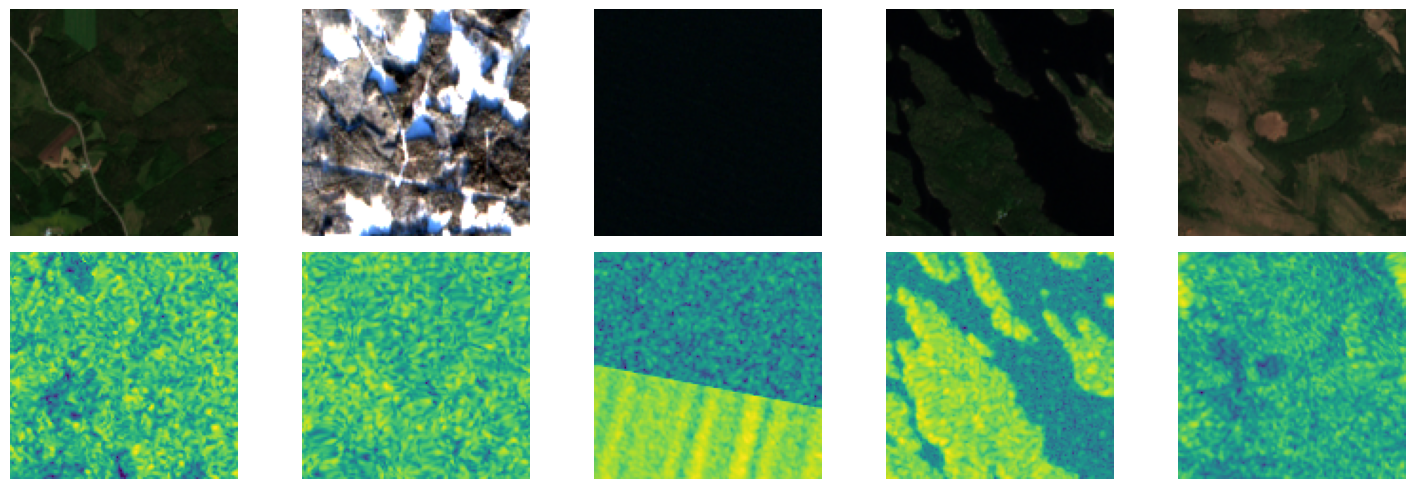

In [15]:
batch = next(iter(ds.train_dataloader()))

s1_imgs, s2_imgs, labels = batch['S1'], batch['S2'], batch['labels']

fig = plt.figure(figsize=(3*len(labels), 5))
th = 3000
for i, (s1, s2, label) in enumerate(zip(s1_imgs, s2_imgs, labels)):
	ax = plt.subplot(2, len(labels), i + 1)
	img = to_uint8(s2, 0, th)
	ax.imshow(img)
	ax.axis('off')
	ax = plt.subplot(2, len(labels), i + 1 + len(labels))
	ax.imshow(s1[...,0])
	ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
class Model(torch.nn.Module):

    def __init__(self, in_chans, num_classes, pretrained=None):
        super().__init__()
        self.model = timm.create_model(
            'resnet34',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )

    def forward(self, x):
        x1, x2 = x # S1, S2
        x1 = 10**(x1 / 10)
        x1 = x1.clip(0, 1)
        x2 = x2 / 4000
        x2 = x2.clip(0, 1)
        x = torch.cat([x1, x2], axis=1) # concatenate images on channels dimension
        return self.model(x)

In [17]:
trans = A.Compose([
    A.Lambda(image=add_channel),                           
    ToTensorV2()                                
], additional_targets={'S1': 'image', 'S2': 'image'}) # this should be handled by the library...

ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=32, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    train_trans=trans,
    val_trans=trans,
    num_workers=8,
    pin_memory=True,
)

model = Model(in_chans=ds.in_chans, num_classes=ds.num_classes)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

task = ImageMultilabelClassification(model, hparams=hparams, metrics={'map': my_map} , inputs=['S1', 'S2'])

In [19]:
trainer = L.Trainer(
    devices=1,
    accelerator='cuda',
    precision="16-mixed",
    max_epochs=3,
	limit_train_batches=100,
    limit_val_batches=100
)

trainer.fit(task, ds)

/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/lightning/fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading ... processed_S2_S1_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.770    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Filter clouds and snow

BigEarthNet has a list of images with clouds and snow. You can filter them out from the dataset like this (only works if S2 images are used).

In [20]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1, S2


ds = BigEarthNet(
    path="/fastdata/BigEarthNet", 
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True,
	filter_snow=True, # will remove ~60k images
    filter_clouds=True # will remove ~10k images
)

ds.setup()

Loading ... processed_S2_S1_LABELS19.json
Training samples 311605
Validation samples 103867
Test samples 103867


In [21]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Arable land, Broad-leaved forest, Mixed fores...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
1,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Coniferous forest, Mixed forest]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Beaches, dunes, sands, Mar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Coniferous forest, Mixed forest, Marine waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Industrial or commercial units, Arable land, ...","[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
590322,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2B_MSI...,"[Broad-leaved forest, Coniferous forest, Mixed...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ..."
590323,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1B_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,[Pastures],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,/fastdata/BigEarthNet/BigEarthNet-S1-v1.0/S1A_...,/fastdata/BigEarthNet/BigEarthNet-v1.0/S2A_MSI...,"[Arable land, Mixed forest, Inland waters]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
